In [1]:
# Read ground truth file

ground_truth = []
ground_truth_file = "/mnt/c/Users/zhenh/tax_data/sampled_reads.label"
with open(ground_truth_file, 'r') as gt:
    for line in gt:
        ground_truth.append(int(line))

In [2]:
# Read GTDB metadata
import pandas as pd

gtdb_metadata = pd.read_csv('/mnt/c/Users/zhenh/tax_data/bac120_metadata.tsv',sep='\t')
species_set = set(gtdb_metadata["ncbi_species_taxid"])
len(species_set)

/tmp/ipykernel_930/2040866023.py:4: DtypeWarning: Columns (61,63,65,74,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  gtdb_metadata = pd.read_csv('/mnt/c/Users/zhenh/tax_data/bac120_metadata.tsv',sep='\t')


57939

In [6]:
gtdb_metadata["ncbi_genbank_assembly_accession"]

0         GCA_001206855.1
1         GCA_001108865.1
2         GCA_000730125.1
3         GCA_000950275.1
4         GCA_000468955.1
               ...       
394927    GCA_934776845.1
394928    GCA_023647245.1
394929    GCA_020344015.1
394930    GCA_945889495.1
394931    GCA_934500585.1
Name: ncbi_genbank_assembly_accession, Length: 394932, dtype: object

In [10]:
# Read Kraken 2 output
kraken2_predictions = []

kraken2_output_file = "/mnt/c/Users/zhenh/tax_data/kraken2.output"

kraken2_predictions = pd.read_csv(kraken2_output_file, sep='\t', header=None)
kraken2_predictions.rename(columns={0: 'classified', 1: 'read_id', 2: 'classification_result', 3: 'read_length', 4: 'LCA'}, inplace=True)
kraken2_predictions.head()


,classified,read_id,classification_result,read_length,LCA
0,C,SRR24651298.1,100886,8663,100886:9 135858:2 100886:3 135858:8 0:28 13585...
1,C,SRR24651298.2,100886,2129,0:30 135858:2 100886:1 135858:12 0:25 100886:5...
2,C,SRR24651298.3,100886,3852,135858:37 100886:12 135858:2 100886:6 135858:3...
3,C,SRR24651298.4,100886,6186,100886:8 135858:12 0:47 100886:23 135858:2 100...
4,C,SRR24651298.5,100886,790,0:5 135858:4 100886:14 135858:1 100886:3 13585...


In [11]:
kraken2_predictions["ground_truth"] = ground_truth

## Unclassified reads

<Axes: xlabel='read_length', ylabel='Density'>

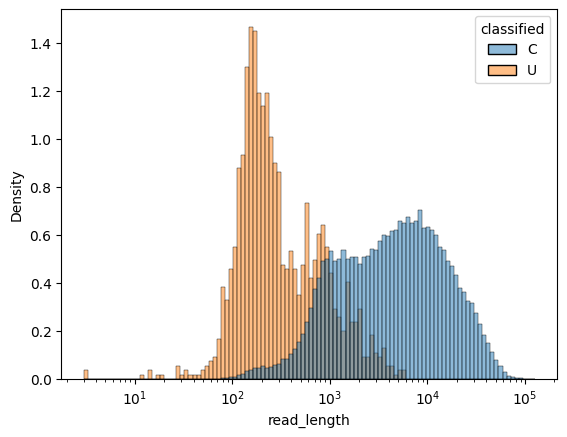

In [12]:
import seaborn as sns

sns.histplot(data=kraken2_predictions, x="read_length", hue="classified", log_scale=True, common_norm=False,
             stat="density")


In [15]:
from collections import Counter
from ete3 import NCBITaxa

ncbi = NCBITaxa()

def LCA_to_dict(LCA):
    res = Counter()
    for item in LCA.split(" "):
        tup = item.split(":")
        res[int(tup[0])] += int(tup[1])
    return res


def get_level(ID, level='genus'):
    """
    Find the genus of a given species ID.
    """
    if ID is None:
        return None
        
    # Get the lineage of the species
    try:
        lineage = ncbi.get_lineage(int(ID))
        ranks = ncbi.get_rank(lineage)
    except:
        return None

    #print(ranks)
    for i in ranks:
        if ranks[i] == level:
            return i
        
    return None


def check_LCA(LCA, ground_truth, level='genus'):
    prediction = LCA_to_dict(LCA)
    acceptable_prediction = 0
    for species in prediction:
        if species != 0:
            if get_level(ground_truth, level) == get_level(species, level):
                acceptable_prediction += prediction[species]
    return acceptable_prediction

def num_unclassified(LCA):
    prediction = LCA_to_dict(LCA)
    return prediction[0]


# Check for the unclassified reads, how many k-mer classification is actually acceptable
correct_classifications_genus = []
correct_classifications_species = []
unclassified_kmers = []
for i in range(len(kraken2_predictions)):
    correct_classifications_genus.append(check_LCA(kraken2_predictions["LCA"][i], kraken2_predictions["ground_truth"][i], 'genus'))
    correct_classifications_species.append(check_LCA(kraken2_predictions["LCA"][i], kraken2_predictions["ground_truth"][i], 'species'))
    unclassified_kmers.append(num_unclassified(kraken2_predictions["LCA"][i]))

kraken2_predictions["correct_at_genus"] = correct_classifications_genus
kraken2_predictions["correct_at_species"] = correct_classifications_species
kraken2_predictions["unclassified_kmers"] = unclassified_kmers

/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 558436 was translated into 838
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


In [23]:
LCA_to_dict(kraken2_predictions["LCA"][0]).values()

dict_values([2365, 749, 5051, 4, 34, 33, 1, 5, 1, 3, 382, 1])

In [24]:
# Check the votes for majority
majority_vote = []
for i in range(len(kraken2_predictions)):
    d = LCA_to_dict(kraken2_predictions["LCA"][i])
    majority_vote.append(max(d.values()))

kraken2_predictions["majority_vote"] = majority_vote

In [50]:
classified = kraken2_predictions[kraken2_predictions["classified"] == 'C']
unclassified = kraken2_predictions[kraken2_predictions["classified"] == 'U']

len(unclassified) / len(kraken2_predictions)

0.018347222222222223

In [58]:
69 / len(unclassified)

0.052233156699470096

In [72]:
kraken2_predictions

,classified,read_id,classification_result,read_length,LCA,ground_truth,correct_at_genus,correct_at_species,unclassified_kmers,predict_at_genus,predict_at_species,species_in_db,at_species_level
0,C,SRR24651298.1,100886,8663,100886:9 135858:2 100886:3 135858:8 0:28 13585...,100886,3148,2365,5051,True,True,True,True
1,C,SRR24651298.2,100886,2129,0:30 135858:2 100886:1 135858:12 0:25 100886:5...,100886,712,211,1356,True,True,True,True
2,C,SRR24651298.3,100886,3852,135858:37 100886:12 135858:2 100886:6 135858:3...,100886,1818,512,1992,True,True,True,True
3,C,SRR24651298.4,100886,6186,100886:8 135858:12 0:47 100886:23 135858:2 100...,100886,1616,638,4425,True,True,True,True
4,C,SRR24651298.5,100886,790,0:5 135858:4 100886:14 135858:1 100886:3 13585...,100886,355,115,396,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71995,C,SRR24651270.996,411464,25452,0:1 901:5 0:50 411464:5 901:1 0:3 901:5 0:23 4...,901,12662,11458,11170,True,True,True,True
71996,C,SRR24651270.997,411464,2122,411464:2 0:57 901:53 0:38 411464:5 901:1 41146...,901,541,534,1508,True,True,True,True
71997,C,SRR24651270.998,411464,11199,0:30 2479851:5 0:6 1930279:1 0:9 901:23 0:16 9...,901,2843,2803,7600,True,True,True,True
71998,C,SRR24651270.999,411464,2373,0:156 411464:3 0:20 411464:12 0:57 411464:11 1...,901,129,129,2192,True,True,True,True


In [74]:
kraken2_predictions[["read_length", "unclassified_kmers"]]

,read_length,unclassified_kmers
0,8663,5051
1,2129,1356
2,3852,1992
3,6186,4425
4,790,396
...,...,...
71995,25452,11170
71996,2122,1508
71997,11199,7600
71998,2373,2192


<Axes: xlabel='unclassified_kmer_percentage'>

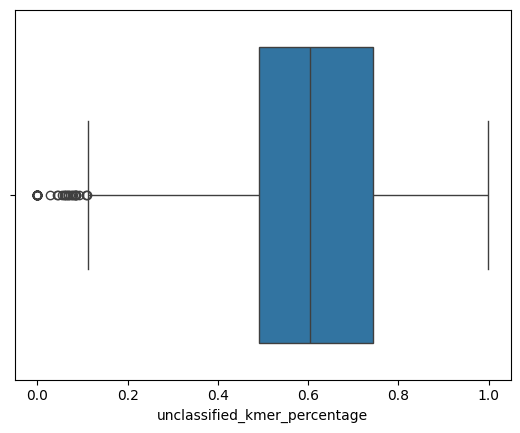

In [80]:
kraken2_predictions["unclassified_kmer_percentage"] = kraken2_predictions["unclassified_kmers"] / (kraken2_predictions["read_length"] - 30)
sns.boxplot(data=kraken2_predictions, orient='h', x="unclassified_kmer_percentage")

In [81]:
np.mean(kraken2_predictions["unclassified_kmer_percentage"])

0.6214902629386245

## Evaluate correctness

In [16]:
# Evaluate correctness
import numpy as np

# Get set of species in GTDB
ground_truth_genus = []
for gt in species_set:
    ground_truth_genus.append(get_level(gt, 'species'))

species_set = set(ground_truth_genus)

species_correct = np.full(len(ground_truth), False, dtype=bool)
genus_correct = np.full(len(ground_truth), False, dtype=bool)
in_db = np.full(len(ground_truth), False, dtype=bool)
prediction_at_species_level = np.full(len(ground_truth), False, dtype=bool)

for i in range(len(ground_truth)):
    if get_level(ground_truth[i], 'species') == get_level(kraken2_predictions["classification_result"][i], 'species'):
        species_correct[i] = True
    if get_level(ground_truth[i]) == get_level(kraken2_predictions["classification_result"][i]):
        genus_correct[i] = True
    if get_level(ground_truth[i], 'species') in species_set:
        in_db[i] = True
    try:
        rank = ncbi.get_rank([kraken2_predictions["classification_result"][i]])
    except:
        rank = None
    if rank is not None and len(rank) != 0:
        #print(rank[kraken2_predictions[i]])
        if rank[kraken2_predictions["classification_result"][i]] in ['species', 'strain']:
            prediction_at_species_level[i] = True

kraken2_predictions["predict_at_genus"] = genus_correct
kraken2_predictions["predict_at_species"] = species_correct
kraken2_predictions["species_in_db"] = in_db
kraken2_predictions["at_species_level"] = prediction_at_species_level

/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1704088 was translated into 1335043
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2823888 was translated into 38303
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 417 was translated into 17
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2750980 was translated into 2070537
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:24

In [63]:
kraken2_predictions

,classified,read_id,classification_result,read_length,LCA,ground_truth,correct_at_genus,correct_at_species,unclassified_kmers,predict_at_genus,predict_at_species,species_in_db,at_species_level
0,C,SRR24651298.1,100886,8663,100886:9 135858:2 100886:3 135858:8 0:28 13585...,100886,3148,2365,5051,True,True,True,True
1,C,SRR24651298.2,100886,2129,0:30 135858:2 100886:1 135858:12 0:25 100886:5...,100886,712,211,1356,True,True,True,True
2,C,SRR24651298.3,100886,3852,135858:37 100886:12 135858:2 100886:6 135858:3...,100886,1818,512,1992,True,True,True,True
3,C,SRR24651298.4,100886,6186,100886:8 135858:12 0:47 100886:23 135858:2 100...,100886,1616,638,4425,True,True,True,True
4,C,SRR24651298.5,100886,790,0:5 135858:4 100886:14 135858:1 100886:3 13585...,100886,355,115,396,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71995,C,SRR24651270.996,411464,25452,0:1 901:5 0:50 411464:5 901:1 0:3 901:5 0:23 4...,901,12662,11458,11170,True,True,True,True
71996,C,SRR24651270.997,411464,2122,411464:2 0:57 901:53 0:38 411464:5 901:1 41146...,901,541,534,1508,True,True,True,True
71997,C,SRR24651270.998,411464,11199,0:30 2479851:5 0:6 1930279:1 0:9 901:23 0:16 9...,901,2843,2803,7600,True,True,True,True
71998,C,SRR24651270.999,411464,2373,0:156 411464:3 0:20 411464:12 0:57 411464:11 1...,901,129,129,2192,True,True,True,True


### Completely wrong classification

In [69]:
kraken2_predictions[kraken2_predictions["classified"] == True][kraken2_predictions["predict_at_genus"] == False][kraken2_predictions["predict_at_species"] == False]

/tmp/ipykernel_22840/2338805114.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kraken2_predictions[kraken2_predictions["classified"] == True][kraken2_predictions["predict_at_genus"] == False][kraken2_predictions["predict_at_species"] == False]
/tmp/ipykernel_22840/2338805114.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kraken2_predictions[kraken2_predictions["classified"] == True][kraken2_predictions["predict_at_genus"] == False][kraken2_predictions["predict_at_species"] == False]


,classified,read_id,classification_result,read_length,LCA,ground_truth,correct_at_genus,correct_at_species,unclassified_kmers,predict_at_genus,predict_at_species,species_in_db,at_species_level


### Classification at a higher level

In [84]:
kraken2_predictions[kraken2_predictions["predict_at_genus"] == True][kraken2_predictions["predict_at_species"] == False][kraken2_predictions["at_species_level"] == False][kraken2_predictions["species_in_db"] == True]

/tmp/ipykernel_22840/3264823123.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kraken2_predictions[kraken2_predictions["predict_at_genus"] == True][kraken2_predictions["predict_at_species"] == False][kraken2_predictions["at_species_level"] == False][kraken2_predictions["species_in_db"] == True]
/tmp/ipykernel_22840/3264823123.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kraken2_predictions[kraken2_predictions["predict_at_genus"] == True][kraken2_predictions["predict_at_species"] == False][kraken2_predictions["at_species_level"] == False][kraken2_predictions["species_in_db"] == True]
/tmp/ipykernel_22840/3264823123.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kraken2_predictions[kraken2_predictions["predict_at_genus"] == True][kraken2_predictions["predict_at_species"] == False][kraken2_predictions["at_species_level"] == False][kraken2_predictions["species_in_db"] == True]


,classified,read_id,classification_result,read_length,LCA,ground_truth,correct_at_genus,correct_at_species,unclassified_kmers,predict_at_genus,predict_at_species,species_in_db,at_species_level,unclassified_kmer_percentage
50,C,SRR24651298.51,135858,441,2:12 526525:5 135858:34 526525:5 2:10 131567:5...,100886,90,0,122,True,False,True,False,0.296837
278,C,SRR24651298.279,135858,882,2:6 2944914:5 2:1 0:17 135858:22 526525:5 2:10...,100886,31,0,564,True,False,True,False,0.661972
312,C,SRR24651298.313,135858,538,0:27 2:5 0:54 1783272:5 0:28 135858:1 0:384,100886,1,0,493,True,False,True,False,0.970472
493,C,SRR24651298.494,135858,293,0:6 135858:10 526525:5 2:10 131567:5 2:30 1315...,100886,44,0,104,True,False,True,False,0.395437
504,C,SRR24651298.505,135858,680,0:7 1239:33 0:39 1239:1 0:2 1239:7 0:62 1239:1...,100886,68,0,409,True,False,True,False,0.629231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66976,C,SRR24651304.977,816,10703,0:425 815:5 0:56 815:22 976:2 815:5 976:3 2:5 ...,818,347,3,9973,True,False,True,False,0.934414
66991,C,SRR24651304.992,816,1997,0:20 816:4 0:142 816:4 0:23 816:4 0:4 816:26 0...,818,544,0,1414,True,False,True,False,0.718861
67053,C,SRR24651179.54,2719231,469,0:42 2719231:6 0:2 2719231:5 0:5 186801:2 0:4 ...,84030,27,0,383,True,False,True,False,0.872437
69801,C,SRR24651174.802,84111,5586,0:1738 1802376:2 0:649 1852619:5 0:164 2045107...,84112,97,0,5369,True,False,True,False,0.966343


### Wrong Classification at lower level

In [87]:
wrong_at_species_level = kraken2_predictions[kraken2_predictions["predict_at_genus"] == True][kraken2_predictions["predict_at_species"] == False][kraken2_predictions["at_species_level"] == True][kraken2_predictions["species_in_db"] == True]
wrong_at_species_level

/tmp/ipykernel_22840/1484281633.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wrong_at_species_level = kraken2_predictions[kraken2_predictions["predict_at_genus"] == True][kraken2_predictions["predict_at_species"] == False][kraken2_predictions["at_species_level"] == True][kraken2_predictions["species_in_db"] == True]
/tmp/ipykernel_22840/1484281633.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wrong_at_species_level = kraken2_predictions[kraken2_predictions["predict_at_genus"] == True][kraken2_predictions["predict_at_species"] == False][kraken2_predictions["at_species_level"] == True][kraken2_predictions["species_in_db"] == True]
/tmp/ipykernel_22840/1484281633.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wrong_at_species_level = kraken2_predictions[kraken2_predictions["predict_at_genus"] == True][kraken2_predictions["predict_at_species"] == False][kraken2_predictions["at_

,classified,read_id,classification_result,read_length,LCA,ground_truth,correct_at_genus,correct_at_species,unclassified_kmers,predict_at_genus,predict_at_species,species_in_db,at_species_level,unclassified_kmer_percentage
412,C,SRR24651298.413,286142,2127,2:1 0:27 1239:2 2:5 0:31 2:21 1239:5 0:1 1239:...,100886,5,0,1513,True,False,True,True,0.721507
1569,C,SRR24651261.570,747375,806,0:1 747375:2 0:65 747375:27 0:483 747375:7 0:6...,102148,58,0,697,True,False,True,True,0.898196
2323,C,SRR24651237.324,876091,7977,0:338 2567896:3 1783272:5 0:1 2801029:5 0:54 8...,1226322,16,0,7814,True,False,True,True,0.983264
2502,C,SRR24651237.503,1855299,199,0:6 1855299:7 186802:7 0:48 1855299:40 0:4 216...,1226322,47,0,105,True,False,True,True,0.621302
2512,C,SRR24651237.513,876091,1108,0:10 216572:6 1855299:1 0:5 1855299:1 0:42 876...,1226322,76,0,908,True,False,True,True,0.842301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66799,C,SRR24651304.800,1236513,2708,2:28 815:7 171549:1 815:5 816:5 0:38 816:3 815...,818,229,0,1350,True,False,True,True,0.504108
66898,C,SRR24651304.899,657309,13896,171549:16 815:5 171549:1 816:5 815:3 816:7 815...,818,8537,62,5220,True,False,True,True,0.376460
66923,C,SRR24651304.924,162156,8842,816:249 0:27 816:42 0:1 816:1 0:20 816:36 0:35...,818,4822,11,3923,True,False,True,True,0.445188
66982,C,SRR24651304.983,657309,1746,0:94 816:2 0:39 816:8 0:119 657309:1 816:16 0:...,818,221,0,1353,True,False,True,True,0.788462


### Wrong classification at genus level

In [93]:
wrong_at_genus_level = kraken2_predictions[kraken2_predictions["predict_at_genus"] == False][kraken2_predictions["classified"] == 'C'][kraken2_predictions["at_species_level"] == True][kraken2_predictions["species_in_db"] == True]
wrong_at_genus_level

/tmp/ipykernel_22840/3259088467.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wrong_at_genus_level = kraken2_predictions[kraken2_predictions["predict_at_genus"] == False][kraken2_predictions["classified"] == 'C'][kraken2_predictions["at_species_level"] == True][kraken2_predictions["species_in_db"] == True]
/tmp/ipykernel_22840/3259088467.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wrong_at_genus_level = kraken2_predictions[kraken2_predictions["predict_at_genus"] == False][kraken2_predictions["classified"] == 'C'][kraken2_predictions["at_species_level"] == True][kraken2_predictions["species_in_db"] == True]
/tmp/ipykernel_22840/3259088467.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wrong_at_genus_level = kraken2_predictions[kraken2_predictions["predict_at_genus"] == False][kraken2_predictions["classified"] == 'C'][kraken2_predictions["at_species_level"] == True][kraken2_

,classified,read_id,classification_result,read_length,LCA,ground_truth,correct_at_genus,correct_at_species,unclassified_kmers,predict_at_genus,predict_at_species,species_in_db,at_species_level,unclassified_kmer_percentage
291,C,SRR24651298.292,1123263,7203,0:93 2:7 0:134 135858:2 1239:1 135858:1 1239:2...,100886,372,175,6312,False,False,True,True,0.879967
1218,C,SRR24651261.219,1219626,10588,0:80 1239:8 0:1 1239:3 0:5 1239:3 0:10 1123263...,102148,31,31,7979,False,False,True,True,0.755730
1248,C,SRR24651261.249,316097,5888,1239:9 2069309:2 0:59 1239:9 0:9 1239:5 0:1 12...,102148,0,0,2731,False,False,True,True,0.466200
1295,C,SRR24651261.296,2652274,14574,0:2 1121128:3 0:4 2:20 0:56 2:10 0:89 2:8 0:17...,102148,0,0,8806,False,False,True,True,0.605473
1396,C,SRR24651261.397,759821,5660,0:4 2:26 0:15 2:1 0:9 2:3 0:1 2:1 0:2 2:68 0:3...,102148,0,0,3253,False,False,True,True,0.577798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70275,C,SRR24651300.276,261299,722,0:35 186804:5 0:9 1783272:1 0:14 261299:13 186...,89153,0,0,284,False,False,True,True,0.410405
71206,C,SRR24651270.207,2652274,10246,0:26 2652274:5 0:31 2652274:43 0:113 2652274:3...,901,0,0,6568,False,False,True,True,0.642913
71586,C,SRR24651270.587,2027858,331,2:3 0:1 2:3 0:1 2:3 0:5 2:25 0:33 2:6 0:50 156...,901,0,0,214,False,False,True,True,0.710963
71623,C,SRR24651270.624,1337051,309,2:15 186801:27 2:5 0:47 2:5 0:141 2:3 0:1 2:1 ...,901,0,0,194,False,False,True,True,0.695341


sns.histplot(data=kraken2_predictions, x="read_length", hue="predict_at_genus", log_scale=True,
             stat="density")

<Axes: xlabel='unclassified_kmer_percentage', ylabel='Density'>

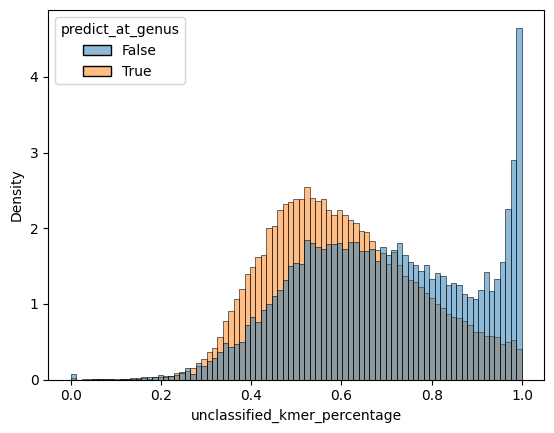

In [111]:
sns.histplot(data=kraken2_predictions, x="unclassified_kmer_percentage", hue="predict_at_genus", common_norm=False,
             stat="density")

<Axes: xlabel='effective_k_mers', ylabel='Density'>

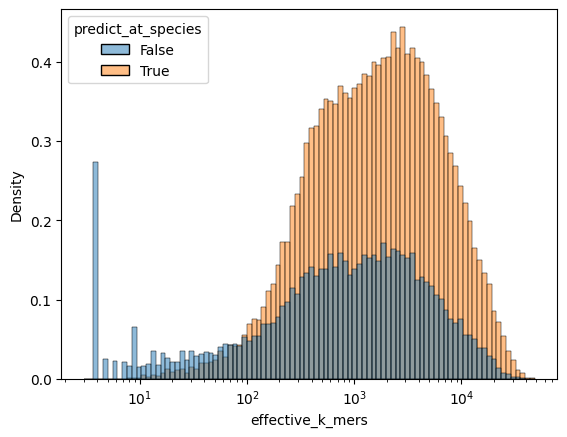

In [119]:
kraken2_predictions["effective_k_mers"] = kraken2_predictions["read_length"] - 30 - kraken2_predictions["unclassified_kmers"]

sns.histplot(data=kraken2_predictions, x="effective_k_mers", hue="predict_at_species", log_scale=True,
             stat="density")

<Axes: xlabel='correct_at_species', ylabel='Density'>

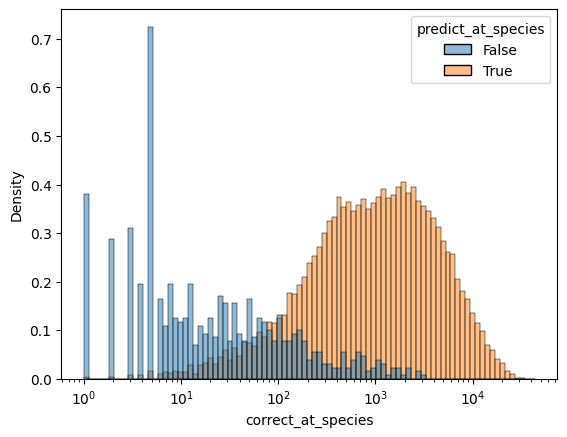

In [19]:
sns.histplot(data=kraken2_predictions, x="correct_at_species", hue="predict_at_species", log_scale=True,
             stat="density")

<Axes: xlabel='majority_vote', ylabel='Density'>

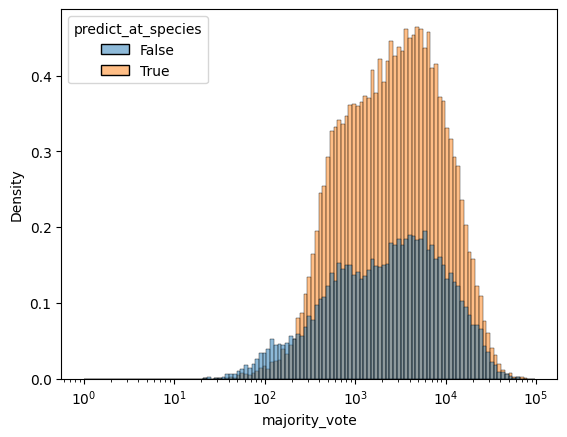

In [25]:
sns.histplot(data=kraken2_predictions, x="majority_vote", hue="predict_at_species", log_scale=True,
             stat="density")

In [34]:
kraken2_predictions

,classified,read_id,classification_result,read_length,LCA,ground_truth,correct_at_genus,correct_at_species,unclassified_kmers,predict_at_genus,predict_at_species,species_in_db,at_species_level,majority_vote
0,C,SRR24651298.1,100886,8663,100886:9 135858:2 100886:3 135858:8 0:28 13585...,100886,3148,2365,5051,True,True,True,True,5051
1,C,SRR24651298.2,100886,2129,0:30 135858:2 100886:1 135858:12 0:25 100886:5...,100886,712,211,1356,True,True,True,True,1356
2,C,SRR24651298.3,100886,3852,135858:37 100886:12 135858:2 100886:6 135858:3...,100886,1818,512,1992,True,True,True,True,1992
3,C,SRR24651298.4,100886,6186,100886:8 135858:12 0:47 100886:23 135858:2 100...,100886,1616,638,4425,True,True,True,True,4425
4,C,SRR24651298.5,100886,790,0:5 135858:4 100886:14 135858:1 100886:3 13585...,100886,355,115,396,True,True,True,True,396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71995,C,SRR24651270.996,411464,25452,0:1 901:5 0:50 411464:5 901:1 0:3 901:5 0:23 4...,901,12662,11458,11170,True,True,True,True,11170
71996,C,SRR24651270.997,411464,2122,411464:2 0:57 901:53 0:38 411464:5 901:1 41146...,901,541,534,1508,True,True,True,True,1508
71997,C,SRR24651270.998,411464,11199,0:30 2479851:5 0:6 1930279:1 0:9 901:23 0:16 9...,901,2843,2803,7600,True,True,True,True,7600
71998,C,SRR24651270.999,411464,2373,0:156 411464:3 0:20 411464:12 0:57 411464:11 1...,901,129,129,2192,True,True,True,True,2192


<Axes: xlabel='read_length', ylabel='Density'>

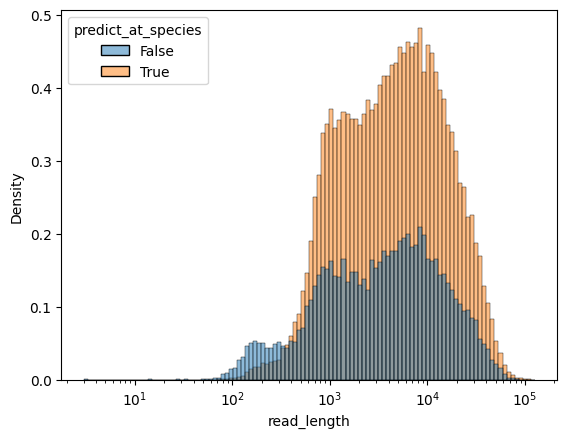

In [120]:
sns.histplot(data=kraken2_predictions, x="read_length", hue="predict_at_species", log_scale=True,
             stat="density")

In [37]:
kraken2_predictions["count"] = np.ones(len(kraken2_predictions))
sum_res = kraken2_predictions[["ground_truth", "predict_at_genus", "predict_at_species", "at_species_level", "species_in_db", "count"]].groupby('ground_truth').sum()
for feature in ["predict_at_genus", "predict_at_species", "at_species_level", "species_in_db"]:
    sum_res[feature] /= sum_res['count']

sum_res

,predict_at_genus,predict_at_species,at_species_level,species_in_db,count
ground_truth,,,,,
817,0.9230,0.889,0.9800,1.0,1000.0
818,0.9645,0.833,0.9560,1.0,2000.0
901,0.9870,0.986,0.9900,1.0,1000.0
1261,0.9740,0.494,0.9905,1.0,2000.0
1358,0.9110,0.785,0.9530,1.0,1000.0
...,...,...,...,...,...
1232452,0.0400,0.000,0.9780,1.0,1000.0
1232457,0.1790,0.000,0.8980,1.0,1000.0
1297617,0.9570,0.957,0.9920,1.0,1000.0


In [38]:
in_domain_res = sum_res[sum_res["species_in_db"] >= 1]

in_domain_res

,predict_at_genus,predict_at_species,at_species_level,species_in_db,count
ground_truth,,,,,
817,0.9230,0.889,0.9800,1.0,1000.0
818,0.9645,0.833,0.9560,1.0,2000.0
901,0.9870,0.986,0.9900,1.0,1000.0
1261,0.9740,0.494,0.9905,1.0,2000.0
1358,0.9110,0.785,0.9530,1.0,1000.0
...,...,...,...,...,...
1226322,0.0100,0.000,0.6900,1.0,1000.0
1232452,0.0400,0.000,0.9780,1.0,1000.0
1232457,0.1790,0.000,0.8980,1.0,1000.0


In [41]:

hard_parts = in_domain_res[in_domain_res["predict_at_species"] < 0.6]

hard_parts

,predict_at_genus,predict_at_species,at_species_level,species_in_db,count
ground_truth,,,,,
1261,0.974,0.494,0.9905,1.0,2000.0
1507,0.001,0.000,0.9590,1.0,1000.0
74426,0.966,0.522,0.9300,1.0,1000.0
154046,0.541,0.541,0.8900,1.0,1000.0
411489,0.002,0.000,0.9690,1.0,1000.0
450749,0.937,0.000,0.9520,1.0,1000.0
457395,0.073,0.000,0.9610,1.0,1000.0
457416,0.873,0.000,0.9150,1.0,1000.0
469588,0.897,0.000,0.9120,1.0,1000.0


In [14]:
ncbi.get_taxid_translator([1507, 1720313])

{1507: 'Clostridium sp. ATCC 29733',
 1720313: 'Bittarella massiliensis (ex Durand et al. 2017)'}

In [8]:
out_domain_res = sum_res[sum_res["in_db"] <= 0]

out_domain_res

,kraken2_predictions,species_correct,genus_correct,in_db,prediction_at_species_level,count
Ground Truth,,,,,,
2860054,1812151353,0.0,0.908,0.0,0.923,1000


/tmp/ipykernel_778/1629055615.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


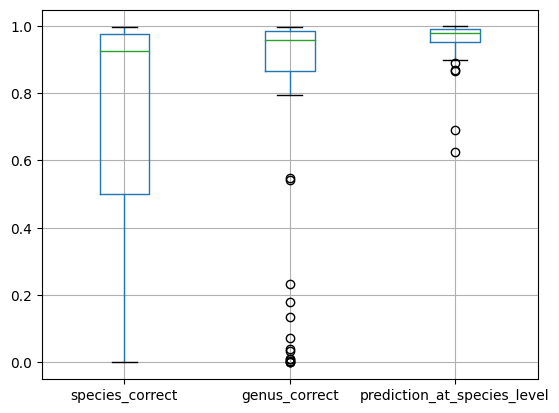

In [12]:
import matplotlib.pyplot as plt

plot = plt.figure()
sum_res.boxplot(column=["species_correct", "genus_correct", "prediction_at_species_level"])
plot.show()
plot.savefig("res.pdf", format='pdf')

## Check contamination

In [29]:
# preprocess metadata
gtdb_species = []
for i in range(len(gtdb_metadata)):
    gtdb_species.append(get_level(gtdb_metadata["ncbi_species_taxid"][i], 'species'))

gtdb_metadata["species_id"] = gtdb_species

/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1313265 was translated into 1302351
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1217702 was translated into 70348
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1217712 was translated into 1776742
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 196180 was translated into 265546
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquer

In [47]:
hard_species_samples = []
hard_species_accessions = []

for species in set(hard_parts.index):
    species_id = get_level(species, 'species')
    ref = gtdb_metadata[gtdb_metadata["species_id"] == species_id]
    accessions = set(ref["ncbi_genbank_assembly_accession"])
    if len(accessions) == 1:
        hard_species_samples.append(species)
        for a in accessions:
            hard_species_accessions.append(a)

In [50]:
import subprocess

import os

os.chdir('/home/zhenhao/tc-benchmark/reference_genome')
for i, a in enumerate(hard_species_accessions):
    subprocess.run(["datasets", "download", "genome", "accession", a, "--filename", str(hard_species_samples[i]) + ".zip"])

New version of client (16.8.1) available at https://ftp.ncbi.nlm.nih.gov/pub/datasets/command-line/LATEST/linux-amd64/datasets
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading: 457395.zip    3.28kB 12MB/s
Downloading:

In [64]:
for zip_file in *.zip
do 
    echo $zip_file
    name=${zip_file%%.*}
    unzip $zip_file
    for fasta_file in $(ls ncbi_dataset/data/*/*.fna)
    do
        cat $fasta_file > ${name}.fasta
    done

    # remove the zip file
    rm -r ncbi_dataset README.md $zip_file
done

1232452.zip  1507.zip    450749.zip  457416.zip  469592.zip  563193.zip
1232457.zip  411489.zip  457395.zip  469588.zip  556261.zip  665956.zip


In [52]:
# pick out the relevant reads
species = []
for i in range(len(kraken2_predictions)):
    species.append(get_level(kraken2_predictions["ground_truth"][i], "species"))

kraken2_predictions["species"] = species

In [56]:
with open("/mnt/c/Users/zhenh/tax_data/sampled_reads.fastq") as f:
    lines = f.readlines()
    #for s in hard_species_samples:
    #    print(kraken2_predictions[kraken2_predictions["species"] == s].index)

@SRR24651309.1 c2025f7b-e0b3-4fea-8582-c2c0e7f66142 length=33967

AGCATCTGAACCACATGGTAAATGTCATGGGCATAGAACATGTAGGGATAGGAACCGATTTTGACGGTGACGGCGGTATCGCAGGCTGCGCTTCGGCATCAGAATTGATAAACTTTACCGCCGGCTGCTGTTGGAAAGATATAGTGAAGAAAGTATCCGCCTGATCTGGGAAACTTCCTGCGCGTTATGGAAGAAGTACAAGAAAATAACGTAACTTTGCGGCACAGATTCTCTATCTTATTAAGGACAATGCACAAATAACAAGGAATAAGTATGAAGATAAAAAACGTTTTAGTAATCCCGGTCTTGCTGCTTGGCAACTGACGGCTGTAGCCTGTGGAAACAGTAAAAGCAGAAACGACCGGACAGAAACCGTAGACAAAGAAGTGATCAAGGCTCCCGAATTCAATGCGGACAGCGCCTGAAGTACATTCAGGTACAAGCTGATTTCGGTCCCCGTGTCCCTAACACGCAGGCGCACAAAGAATGTGGGGAATATCTGGCAGGACAATTGGAAAATTCGGAGCCAGGTATACAATCAATATGCTGATTTGATAGCTTATGATGGTACTATACTGAAATCACGCAACATTATCGGCGCTTACAAGCCCGAAAGTAAAAAACGCGTCCTGCTTTGCGCCCATTGGGACAGCCTTACGTATGCCGACAATGATCCCGACCCGAAAAATCACCACACTCCTATTTTAGGAGTAAATGATGGCGCCAGTGGTGTAGGTGTGTTATTGGAAATCGCCCGTCAGATACAGAAAGAACAACCTGCTCTGAACACATAGATATCGTGTTTTTGATTCGGAGAGTTATGGAATTCCTGAATTTTATGGCGGCAGACAAACAAGACACTTGGTGCCTTGGTTCACAATACTGGGCACGTACCCCACATGTTCAGAACTATAATGCACGCTATGGAGTCTTT

In [59]:
for i in range(176000, 176004):
    print(lines[i])

@SRR24651309.1 c2025f7b-e0b3-4fea-8582-c2c0e7f66142 length=33967

AGCATCTGAACCACATGGTAAATGTCATGGGCATAGAACATGTAGGGATAGGAACCGATTTTGACGGTGACGGCGGTATCGCAGGCTGCGCTTCGGCATCAGAATTGATAAACTTTACCGCCGGCTGCTGTTGGAAAGATATAGTGAAGAAAGTATCCGCCTGATCTGGGAAACTTCCTGCGCGTTATGGAAGAAGTACAAGAAAATAACGTAACTTTGCGGCACAGATTCTCTATCTTATTAAGGACAATGCACAAATAACAAGGAATAAGTATGAAGATAAAAAACGTTTTAGTAATCCCGGTCTTGCTGCTTGGCAACTGACGGCTGTAGCCTGTGGAAACAGTAAAAGCAGAAACGACCGGACAGAAACCGTAGACAAAGAAGTGATCAAGGCTCCCGAATTCAATGCGGACAGCGCCTGAAGTACATTCAGGTACAAGCTGATTTCGGTCCCCGTGTCCCTAACACGCAGGCGCACAAAGAATGTGGGGAATATCTGGCAGGACAATTGGAAAATTCGGAGCCAGGTATACAATCAATATGCTGATTTGATAGCTTATGATGGTACTATACTGAAATCACGCAACATTATCGGCGCTTACAAGCCCGAAAGTAAAAAACGCGTCCTGCTTTGCGCCCATTGGGACAGCCTTACGTATGCCGACAATGATCCCGACCCGAAAAATCACCACACTCCTATTTTAGGAGTAAATGATGGCGCCAGTGGTGTAGGTGTGTTATTGGAAATCGCCCGTCAGATACAGAAAGAACAACCTGCTCTGAACACATAGATATCGTGTTTTTGATTCGGAGAGTTATGGAATTCCTGAATTTTATGGCGGCAGACAAACAAGACACTTGGTGCCTTGGTTCACAATACTGGGCACGTACCCCACATGTTCAGAACTATAATGCACGCTATGGAGTCTTT

In [61]:
for s in hard_species_samples:
    with open("../reads/" + str(s) + ".fastq", "w") as f:
        for i in kraken2_predictions[kraken2_predictions["species"] == s].index:
            for j in range(4 * i, 4 * i + 4):
                f.write(lines[j])
    #print(kraken2_predictions[kraken2_predictions["species"] == s].index)

In [ ]:
mkdir -p ../map

for ref_file in *.fasta
do 
    echo $ref_file
    name=${ref_file%%.*}
    
    # perform minimap
    minimap2 -a $ref_file ../reads/${name}.fastq > ../map/${name}.sam
done

In [93]:
# Analyze the sam files
import pysam
import glob

read_name = []
map_quality = []
read_identity = []


for sam_file in glob.glob("../map/*.sam"):
    f = pysam.AlignmentFile(sam_file,'rb')
    for read in f.fetch():
        read_name.append(read.query_name)
        map_quality.append(read.mapping_quality)
        identity = 0
        for t, n in read.cigar:
            if t == 0:
                identity += n
        read_identity.append(identity)
    

In [94]:
mapping_df = pd.DataFrame({"read_name": read_name, "map_quality": map_quality, "read_identity": read_identity})
mapping_df

,read_name,map_quality,read_identity
0,SRR24651235.1,60,310
1,SRR24651235.2,60,8759
2,SRR24651235.3,60,11748
3,SRR24651235.4,60,24310
4,SRR24651235.4,60,2580
...,...,...,...
14363,SRR24651311.996,60,914
14364,SRR24651311.997,60,4254
14365,SRR24651311.998,60,4765
14366,SRR24651311.999,60,8309


In [96]:
kraken2_with_mapping_res = kraken2_predictions.set_index('read_id').join(mapping_df.set_index('read_name'), how='inner')

In [97]:
kraken2_with_mapping_res

,classified,classification_result,read_length,LCA,ground_truth,correct_at_genus,correct_at_species,unclassified_kmers,predict_at_genus,predict_at_species,species_in_db,at_species_level,majority_vote,count,species,map_quality,read_identity
read_id,,,,,,,,,,,,,,,,,
SRR24651194.1,C,435591,22246,0:17 435591:12 0:1 823:1 0:27 435591:3 823:3 3...,563193,9632,0,11141,True,False,True,True,11141,1.0,563193,60,22017
SRR24651194.10,C,435591,13280,0:997 976:5 0:1607 2496559:5 0:60 185007:2 0:4...,563193,1787,0,11226,True,False,True,True,11226,1.0,563193,60,13153
SRR24651194.100,C,435591,2245,0:23 1218111:4 0:169 927665:6 0:444 435591:123...,563193,275,0,1918,True,False,True,True,1918,1.0,563193,60,650
SRR24651194.100,C,435591,2245,0:23 1218111:4 0:169 927665:6 0:444 435591:123...,563193,275,0,1918,True,False,True,True,1918,1.0,563193,60,525
SRR24651194.100,C,435591,2245,0:23 1218111:4 0:169 927665:6 0:444 435591:123...,563193,275,0,1918,True,False,True,True,1918,1.0,563193,60,549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR24651321.996,C,2763022,947,0:39 2763022:6 815:9 0:86 2763022:3 0:144 2919...,469588,14,0,886,True,False,True,True,886,1.0,469588,60,911
SRR24651321.997,C,657309,6592,0:13 816:149 0:52 816:20 0:28 816:27 0:28 816:...,469588,3007,0,3515,True,False,True,True,3515,1.0,469588,60,6494
SRR24651321.998,C,85831,12723,85831:5 0:26 85831:6 0:48 816:1 0:8 85831:2 0:...,469588,932,0,11601,True,False,True,True,11601,1.0,469588,60,7223


In [99]:
kraken2_with_mapping_res["read_identity"] /= kraken2_with_mapping_res["read_length"]

In [100]:
kraken2_with_mapping_res

,classified,classification_result,read_length,LCA,ground_truth,correct_at_genus,correct_at_species,unclassified_kmers,predict_at_genus,predict_at_species,species_in_db,at_species_level,majority_vote,count,species,map_quality,read_identity
read_id,,,,,,,,,,,,,,,,,
SRR24651194.1,C,435591,22246,0:17 435591:12 0:1 823:1 0:27 435591:3 823:3 3...,563193,9632,0,11141,True,False,True,True,11141,1.0,563193,60,0.989706
SRR24651194.10,C,435591,13280,0:997 976:5 0:1607 2496559:5 0:60 185007:2 0:4...,563193,1787,0,11226,True,False,True,True,11226,1.0,563193,60,0.990437
SRR24651194.100,C,435591,2245,0:23 1218111:4 0:169 927665:6 0:444 435591:123...,563193,275,0,1918,True,False,True,True,1918,1.0,563193,60,0.289532
SRR24651194.100,C,435591,2245,0:23 1218111:4 0:169 927665:6 0:444 435591:123...,563193,275,0,1918,True,False,True,True,1918,1.0,563193,60,0.233853
SRR24651194.100,C,435591,2245,0:23 1218111:4 0:169 927665:6 0:444 435591:123...,563193,275,0,1918,True,False,True,True,1918,1.0,563193,60,0.244543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR24651321.996,C,2763022,947,0:39 2763022:6 815:9 0:86 2763022:3 0:144 2919...,469588,14,0,886,True,False,True,True,886,1.0,469588,60,0.961985
SRR24651321.997,C,657309,6592,0:13 816:149 0:52 816:20 0:28 816:27 0:28 816:...,469588,3007,0,3515,True,False,True,True,3515,1.0,469588,60,0.985133
SRR24651321.998,C,85831,12723,85831:5 0:26 85831:6 0:48 816:1 0:8 85831:2 0:...,469588,932,0,11601,True,False,True,True,11601,1.0,469588,60,0.567712


<Axes: xlabel='read_identity', ylabel='Density'>

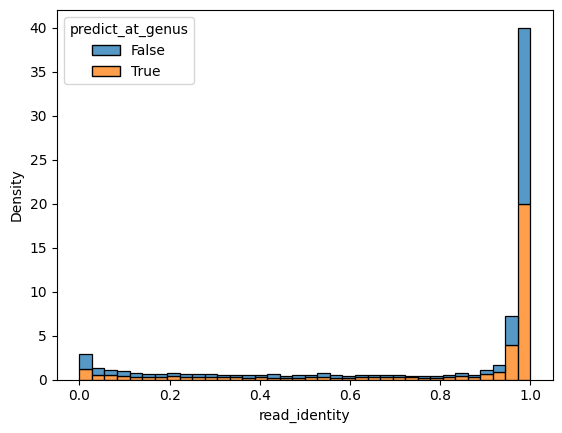

In [107]:
sns.histplot(data=kraken2_with_mapping_res, x="read_identity", hue="predict_at_genus", common_norm=False,
             stat="density", multiple="stack")

<Axes: xlabel='correct_at_genus', ylabel='Density'>

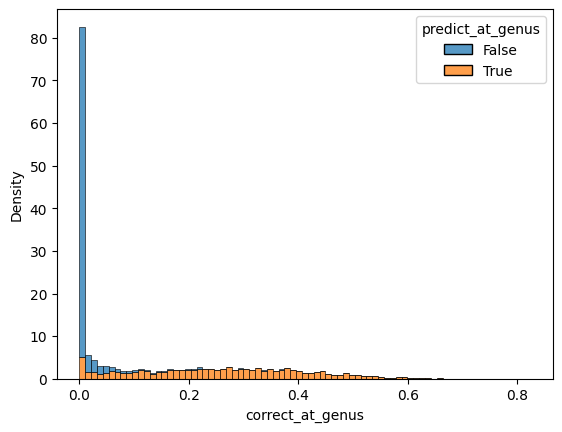

In [121]:
sns.histplot(data=kraken2_with_mapping_res, x="correct_at_genus", hue="predict_at_genus", common_norm=False,
             stat="density", multiple="stack")

<Axes: >

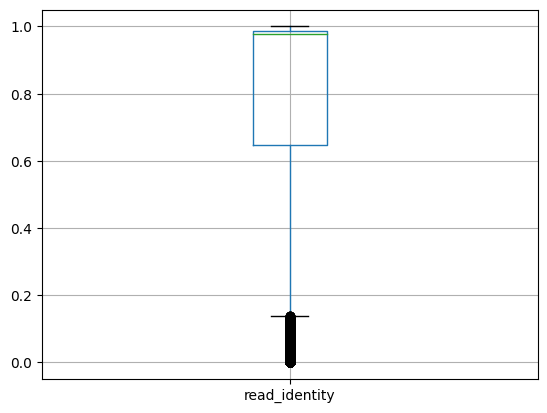

In [109]:
kraken2_with_mapping_res.boxplot("read_identity")

In [115]:
kraken2_with_mapping_res["predict_at_genus"].mean()

0.30839365256124723

In [118]:
kraken2_with_mapping_res["correct_at_genus"] /= kraken2_with_mapping_res["read_length"]


<Axes: xlabel='read_identity', ylabel='correct_at_genus'>

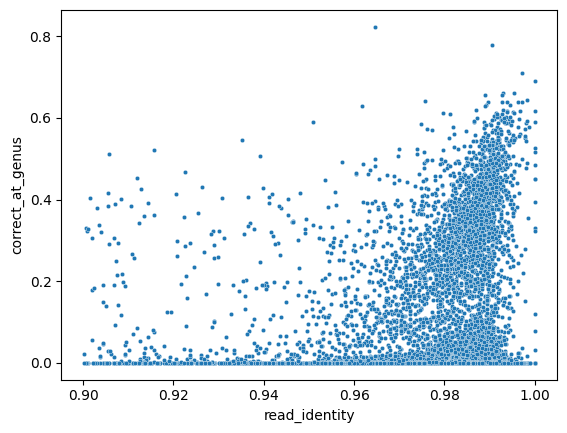

In [122]:
kraken2_with_high_read_identity = kraken2_with_mapping_res[kraken2_with_mapping_res["read_identity"] >= 0.9]
sns.scatterplot(data=kraken2_with_high_read_identity, x="read_identity", y="correct_at_genus", s=10)